In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy import units as u

## Class to organize auto- and cross-spectra of components at different frequencies

In [60]:
class spectra():
    
    def __init__(self, base_dir, ellmax, freqs, comps, gg_shot_noise, noise=None):
        self.base_dir = base_dir
        self.ellmax = ellmax
        self.freqs = freqs
        self.comps = comps
        self.gg_shot_noise = gg_shot_noise
        self.noise = noise #dimensions (nfreqs x ellmax)
        #index as all_spectra[a][i][b][j] for cross-spectrum of component a at frequency i with component b at frequency j
        self.all_spectra = np.zeros((len(comps), len(freqs), len(comps), len(freqs), ellmax+1)) 
        #index as comp_cross_g_spectra[a][i] for cross-spectrum of g with component a at frequency i
        self.comp_cross_g_spectra = np.zeros((len(comps), len(freqs), ellmax+1))
        #gg auto-spectrum
        self.gg_spectrum = np.zeros(ellmax+1)
        #list of ells
        self.ells = np.arange(ellmax+1)
    
    @staticmethod
    def get_file_name(base_dir, freq1, freq2, comp1, comp2):
        fname = f'{base_dir}/ell_dl_'
        if comp1==comp2=='CMB':
            return f'{base_dir}/ell_dl_CMB.txt'
        if comp1==comp2=='gg':
            return f'{base_dir}/ell_dl_gg.txt'
        fname += f'{freq1}x{freq2}_GHz_{comp1}x{comp2}.txt' 
        return fname
    
    def log_interp(self, ells, spectrum):
        if np.all(spectrum >= 0):
            log_spectrum = np.log(spectrum)
            f = interp1d(ells, log_spectrum, fill_value="extrapolate")
            return np.exp(f(self.ells))
        else:
            log_neg_spectrum = np.log(-spectrum)
            f = interp1d(ells, log_neg_spectrum, fill_value="extrapolate")
            return -np.exp(f(self.ells))
    
    
    def get_ksz_auto_spectra(self, plot=False):
        ksz_patchy_file = open('ILC_class-sz_curves/FBN_kSZ_PS_patchy.d.txt', 'r')
        rows = ksz_patchy_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        cols = np.transpose(rows)
        ells_ksz_patchy, ksz_patchy = cols
        ksz_patchy = self.log_interp(ells_ksz_patchy, ksz_patchy)

        ksz_nonpatchy_file = open('ILC_class-sz_curves/FBN_kSZ_PS.d.txt', 'r')
        rows = ksz_nonpatchy_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        cols = np.transpose(rows)
        ells_ksz_nonpatchy, ksz_nonpatchy = cols
        ksz_nonpatchy = self.log_interp(ells_ksz_nonpatchy, ksz_nonpatchy)

        ksz = ksz_patchy + ksz_nonpatchy

        if plot:
            plt.clf()
            plt.plot(self.ells, ksz_patchy, label='patchy')
            plt.plot(self.ells, ksz_nonpatchy, label='non-patchy')
            plt.plot(self.ells, ksz, label='total kSZ')
            plt.title('kSZ Auto-Spectra')
            plt.legend()
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
        ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
#         ksz[0] = 0
        return ksz
    
    def get_noise_auto_spectra(self,plot=False):
        noise_file = open('ILC_class-sz_curves/nl_advact_20uK_1p5arcmin_uK2_170422.txt', 'r')
        rows = noise_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        cols = np.transpose(rows)
        ells_noise, noise = cols
        noise = self.log_interp(ells_noise, noise)
        if plot:
            plt.plot(self.ells, self.ells*(self.ells+1)*noise/(2*np.pi)) #noise needs to be put into Dl for plotting
            plt.title('Noise Auto-Spectrum')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
        return noise
    
    @staticmethod
    def tsz_spectral_response(freqs): #input frequency in GHz
        T_cmb = 2.726
        h = 6.62607004*10**(-34)
        kb = 1.38064852*10**(-23)
        f = 1. #fsky
        response = []
        for freq in freqs:
            x = h*(freq*10**9)/(kb*T_cmb) #x is v/56.9 GHz
            response.append(T_cmb*(x*1/np.tanh(x/2)-4)) #was factor of tcmb microkelvin before
        return np.array(response)

    
    def populate_all_spectra(self, plot=False):
        #populate all_spectra with files, index as all_spectra[a][i][b][j]
        for a, comp1 in enumerate(self.comps):
            for i, freq1 in enumerate(self.freqs):
                plt.clf()
                for b, comp2 in enumerate(self.comps):
                    for j, freq2 in enumerate(self.freqs):
                        if comp1==comp2=='kSZ':
                            spectrum = self.get_ksz_auto_spectra()
                        elif comp1=='kSZ' or comp2=='kSZ': #kSZ cross anything is 0
                            continue
                        elif comp1==comp2=='noise':
                            if i==j:
                                if self.noise is None:
                                    spectrum = self.get_noise_auto_spectra()
                                else:
                                    spectrum = self.noise[i]
                            else:
                                spectrum = np.zeros(self.ellmax+1)
                        elif comp1=='noise' or comp2=='noise': #noise cross anything is 0
                            continue
                        elif (comp1=='CMB' or comp2=='CMB') and not (comp1=='CMB' and comp2=='CMB'): #CMB cross anything is 0
                            continue
                        else:
                            file = open(self.get_file_name(self.base_dir, freq1, freq2, comp1, comp2), 'r')
                            ells_here, spectrum = file.readlines()
                            ells_here = np.asarray(ells_here.split(' '), dtype=np.float32)
                            spectrum = np.asarray(spectrum.split(' '), dtype=np.float32)
                            spectrum = self.log_interp(ells_here, spectrum)
                            spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
                        self.all_spectra[a][i][b][j] = spectrum
                        if plot:
                            plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
                if plot:
                    plt.xlabel(r'$\ell$')
                    plt.ylabel(r'$D_{\ell}$')
                    plt.legend()
                    plt.show()
        return self.all_spectra
    
    def populate_comp_cross_g_spectra(self, plot=False):
        #populate comp_cross_g_spectra, index as comp_cross_g_spectra[a][i]
        plt.clf()
        for a, comp in enumerate(self.comps):
            if comp=='kSZ' or comp=='noise' or comp=='CMB':
                continue
            for i, freq in enumerate(self.freqs):
                file = open(self.get_file_name(self.base_dir, freq, freq, comp, 'g'), 'r')
                ells_here, spectrum = file.readlines()
                ells_here = np.asarray(ells_here.split(' '), dtype=np.float32)
                spectrum = np.asarray(spectrum.split(' '), dtype=np.float32)
                f_spectrum = interp1d(ells_here, spectrum, fill_value="extrapolate")
                spectrum = f_spectrum(self.ells)
                spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
                spectrum[0] = 0
                self.comp_cross_g_spectra[a][i] = spectrum
                if plot:
                    plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp} {freq} GHz x g')
        if plot:
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.legend()
            plt.show()
        return self.comp_cross_g_spectra 
    
    def populate_gg_spectrum(self, plot=False):
        #populate gg auto-spectrum, index as gg_spectrum[l]
        plt.clf()
        file = open(f'ILC_class-sz_curves/ell_dl_gg.txt', 'r')
        ells_gg, gg = file.readlines()
        ells_gg = np.asarray(ells_gg.split(' '), dtype=np.float32)
        gg = np.asarray(gg.split(' '), dtype=np.float32)
        f_gg = interp1d(ells_gg, gg, fill_value="extrapolate")
        gg = f_gg(self.ells)
        if plot:
            plt.plot(self.ells, gg, label='gg signal')
            plt.plot(self.ells, self.ells*(self.ells+1)*self.gg_shot_noise/(2*np.pi), label='gg shot noise')
            plt.plot(self.ells, gg+self.ells*(self.ells+1)*self.gg_shot_noise/(2*np.pi), label='total gg spectrum')
            plt.title(f'gg Auto-Spectrum')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
            plt.yscale('log')
            plt.legend()
            plt.show()
        self.gg_spectrum_signal = gg/(self.ells*(self.ells+1))*(2*np.pi)
        self.gg_spectrum_signal[0] = 0
        self.gg_spectrum = self.gg_spectrum_signal + self.gg_shot_noise
        return self.gg_spectrum
    
    def get_cls(self, plot=False):
        self.populate_all_spectra(plot=plot)
        self.populate_comp_cross_g_spectra(plot=plot)
        self.populate_gg_spectrum(plot=plot)
        self.Clij = np.einsum('aibjl->ijl', self.all_spectra) #index as Clij[i][j][l]
        self.Clig = np.einsum('ail->il', self.comp_cross_g_spectra) #index as Clig[i][l]
        self.Clgg = self.gg_spectrum
        if plot:
            plt.clf()
            for i in range(len(freqs)):
                for j in range(len(freqs)):
                    plt.plot(self.ells, self.ells*(self.ells+1)*self.Clij[i][j]/(2*np.pi), label=r'$D_{\ell}$ '+f'{freqs[i]}, {freqs[j]}')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.title(r'$D_{\ell}^{ij}$')
            plt.yscale('log')
            plt.legend()
            plt.show()

            plt.clf()
            for i in range(len(freqs)):
                plt.plot(self.ells, self.ells*(self.ells+1)*self.Clig[i]/(2*np.pi), label=f'{freqs[i]} GHz')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.title(r'$D_{\ell}^{ig}$')
            plt.legend()
            plt.show()

            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clgg/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.title(r'$D_{\ell}^{gg}$')
            plt.yscale('log')
            plt.show()
        return self.Clij, self.Clig, self.Clgg

## Class to compute results for Method 1 (explicitly adding zero cross-correlation constraint)

In [39]:
class Method1():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
#         self.Clgg = spectra.Clgg
        self.spectra = spectra
        self.deltal = deltal
    
    def Rlij(self):
        #Get R_{\ell}^{ij}
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1))
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def Rlij_inv(self):
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) #index as Rlij_inv[l][i][j]
        return self.Rlij_inv
    
    def get_abc(self):
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = spectra.tsz_spectral_response(self.freqs) #index as b[i]
        self.c = self.Clig #index as c[i][l]
        return self.a, self.b, self.c
    
    def get_ABCDEFQ(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.C = np.einsum('lij,il,jl->l', self.Rlij_inv, self.c, self.c)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        self.E = np.einsum('lij,i,jl->l', self.Rlij_inv, self.a, self.c)
        self.F = np.einsum('lij,i,jl->l', self.Rlij_inv, self.b, self.c)
        self.Q = np.einsum('l,l,l->l', self.A, self.B, self.C) + 2*np.einsum('l,l,l->l', self.D, self.E, self.F) \
            - np.einsum('l,l,l->l', self.A, self.F, self.F) - np.einsum('l,l,l->l', self.B, self.E, self.E) \
            - np.einsum('l,l,l->l', self.C, self.D, self.D)
        self.Q[0] = 1
        return self.A, self.B, self.C, self.D, self.E, self.F, self.Q
    
    def weights(self):
        #Define weights
        self.w = np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.B, self.C, self.a) \
            - np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.F, self.F, self.a) \
            + np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.E, self.F, self.b) \
            - np.einsum('lij,l,l,l,i->jl', self.Rlij_inv, 1/self.Q, self.C, self.D, self.b) \
            + np.einsum('lij,l,l,l,il->jl', self.Rlij_inv, 1/self.Q, self.D, self.F, self.c) \
            - np.einsum('lij,l,l,l,il->jl', self.Rlij_inv, 1/self.Q, self.B, self.E, self.c)
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.Rlij()
        self.Rlij_inv()
        self.get_abc()
        self.get_ABCDEFQ()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij)
        if plot:
            plt.clf()
            plt.plot(self.ells[2:], (self.ells*(self.ells+1)*self.Clyy/(2*np.pi))[2:])
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (Method 1)')
            plt.show()
        return self.Clyy
        
        

## Class to compute results for Method 2 (implicitly including zero cross-correlation constraint by adding g as a "temperature" map and requiring zero response to it)

In [40]:
class Method2():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.Clgg = spectra.Clgg
        self.spectra = spectra
        self.deltal = deltal
    
    def Rlij_prime(self):
        #Construct Rlij_prime
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        x_no_binning = np.einsum('l,il->il', prefactor, self.Clig)
        alpha_no_binning = np.einsum('l,l->l', prefactor, self.Clgg)
        self.Rlij_prime = np.zeros((len(self.freqs)+1, len(self.freqs)+1, self.ellmax+1)) #+1 after len(freqs) is for g row/col
        for i in range(len(self.freqs)+1):
            for j in range(len(self.freqs)+1):
                if i==j==len(self.freqs): 
                    self.Rlij_prime[i][j] = (np.convolve(alpha_no_binning, np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
                    continue
                elif i==len(self.freqs):
                    self.Rlij_prime[i][j] = (np.convolve(x_no_binning[j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
                    continue
                elif j==len(self.freqs):
                    self.Rlij_prime[i][j] = (np.convolve(x_no_binning[i], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
                    continue
                self.Rlij_prime[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij_prime
    
    def Rlij_prime_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_prime_inv = np.array([np.linalg.inv(self.Rlij_prime[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_prime_inv #index as Rlij_prime_inv[l][i][j]
        
    def get_aprime_bprime(self):
        a = np.ones(len(self.freqs)) #index as a[i]
        b = spectra.tsz_spectral_response(self.freqs) #index as b[i]
        self.a_prime = np.concatenate((a, [0]), axis=None)
        self.b_prime = np.concatenate((b, [0]), axis=None)
        return self.a_prime, self.b_prime
    
    def get_Aprime_Bprime_Dprime(self):
        self.A_prime = np.einsum('lij,i,j->l', self.Rlij_prime_inv, self.a_prime, self.a_prime)
        self.B_prime = np.einsum('lij,i,j->l', self.Rlij_prime_inv, self.b_prime, self.b_prime)
        self.D_prime = np.einsum('lij,i,j->l', self.Rlij_prime_inv, self.a_prime, self.b_prime)
        return self.A_prime, self.B_prime, self.D_prime
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,l,i->jl', self.Rlij_prime_inv, self.B_prime, self.a_prime) \
                    - np.einsum('lij,l,i->jl', self.Rlij_prime_inv, self.D_prime, self.b_prime)
        denominator = np.einsum('l,l->l', self.A_prime, self.B_prime) - np.einsum('l,l->l', self.D_prime, self.D_prime)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.Rlij_prime()
        self.Rlij_prime_inv()
        self.get_aprime_bprime()
        self.get_Aprime_Bprime_Dprime()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w[:-1], self.w[:-1], self.Clij) \
                + 2*np.einsum('il,l,il->l', self.w[:-1], self.w[-1], self.Clig) \
                + np.einsum('l,l,l->l', self.w[-1], self.w[-1], self.Clgg)
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (Method 2)')
            plt.show()
        return self.Clyy
        

## Class for performing regular ILC (preserved CMB, deprojected tSZ) but with no CIB component and no constraints on g

In [41]:
class ILC_no_CIB():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        cib_idx = self.comps.index('CIB')
        self.all_spectra = np.delete(np.copy(spectra.all_spectra), (cib_idx), axis=0)
        self.all_spectra = np.delete(self.all_spectra, (cib_idx), axis=2)
        self.Clij = np.einsum('aibjl->ijl', self.all_spectra) #index as Clij[i][j][l]
        self.spectra = spectra
        self.deltal = deltal
    
    def Rlij(self):
        #Construct Rlij
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = spectra.tsz_spectral_response(self.freqs) #index as b[i]
        return self.a, self.b
    
    def get_ABD(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        return self.A, self.B, self.D
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,l,i->jl', self.Rlij_inv, self.B, self.a) \
                    - np.einsum('lij,l,i->jl', self.Rlij_inv, self.D, self.b)
        denominator = np.einsum('l,l->l', self.A, self.B) - np.einsum('l,l->l', self.D, self.D)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.Rlij()
        self.Rlij_inv()
        self.get_ab()
        self.get_ABD()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij) 
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (ILC without CIB)')
            plt.show()
        return self.Clyy
        

## Class for performing regular ILC (preserved CMB, deprojected tSZ) with all components including CIB but no constraints on g

In [42]:
class ILC_no_g():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.spectra = spectra
        self.Clij = spectra.Clij
        self.deltal = deltal
    
    def Rlij(self):
        #Construct Rlij
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = spectra.tsz_spectral_response(self.freqs) #index as b[i]
        return self.a, self.b
    
    def get_ABD(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        return self.A, self.B, self.D
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,l,i->jl', self.Rlij_inv, self.B, self.a) \
                    - np.einsum('lij,l,i->jl', self.Rlij_inv, self.D, self.b)
        denominator = np.einsum('l,l->l', self.A, self.B) - np.einsum('l,l->l', self.D, self.D)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.Rlij()
        self.Rlij_inv()
        self.get_ab()
        self.get_ABD()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij) 
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (ILC without CIB)')
            plt.show()
        return self.Clyy
        

## Example with 4 frequencies, 4 components and noise

<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.

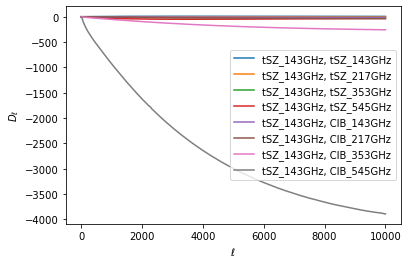

<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.

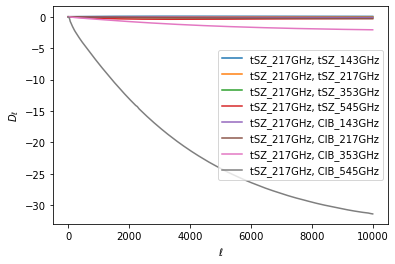

<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.

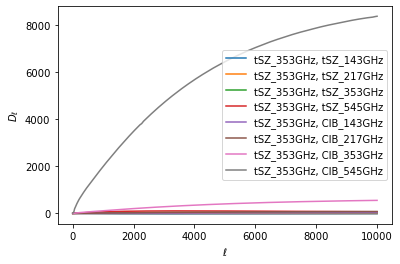

<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.

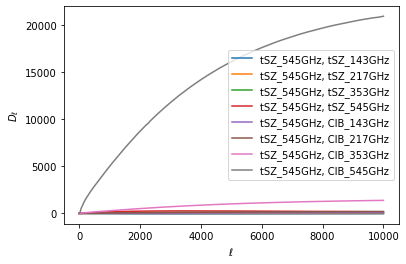

<ipython-input-60-13ad04d208a4>:31: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
<ipython-input-60-13ad04d208a4>:70: RuntimeWarning: divide by zero encountered in true_divide
  ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:31: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)
/opt/anaconda3/lib/python3.8/site-packages/scipy/in

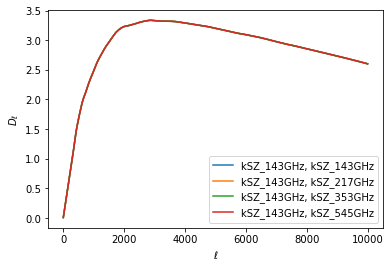

<ipython-input-60-13ad04d208a4>:31: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
<ipython-input-60-13ad04d208a4>:70: RuntimeWarning: divide by zero encountered in true_divide
  ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:31: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)
/opt/anaconda3/lib/python3.8/site-packages/scipy/in

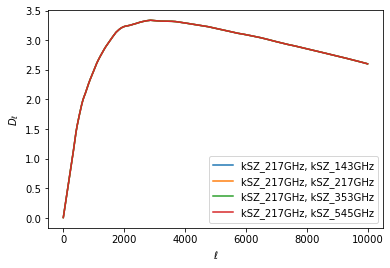

<ipython-input-60-13ad04d208a4>:31: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
<ipython-input-60-13ad04d208a4>:70: RuntimeWarning: divide by zero encountered in true_divide
  ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:31: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)
/opt/anaconda3/lib/python3.8/site-packages/scipy/in

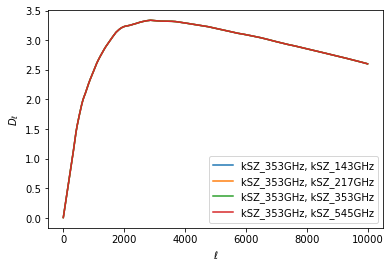

<ipython-input-60-13ad04d208a4>:31: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:626: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
<ipython-input-60-13ad04d208a4>:70: RuntimeWarning: divide by zero encountered in true_divide
  ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:31: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)
/opt/anaconda3/lib/python3.8/site-packages/scipy/in

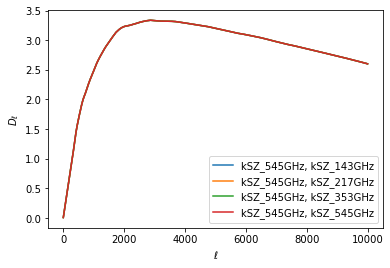

<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.

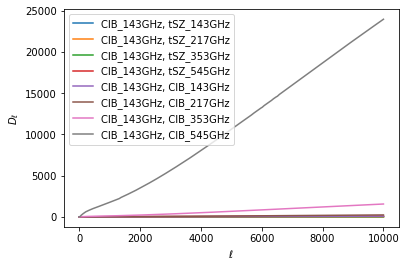

<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.

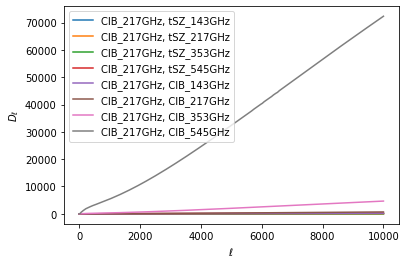

<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.

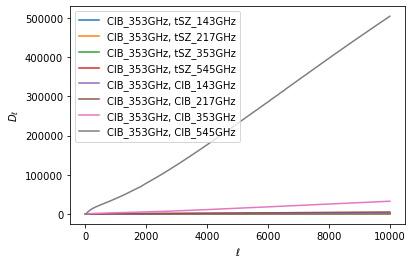

<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
<ipython-input-60-13ad04d208a4>:132: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:135: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.

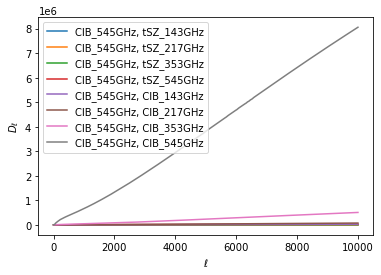

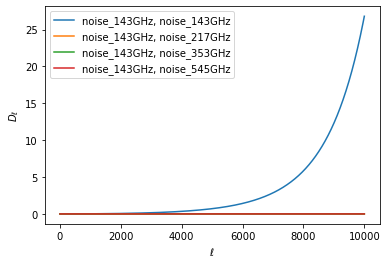

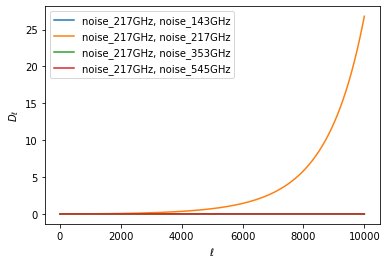

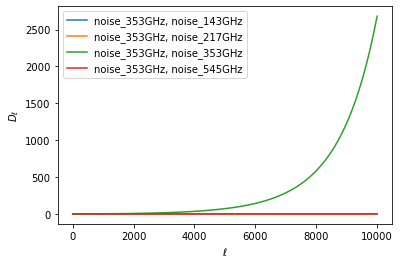

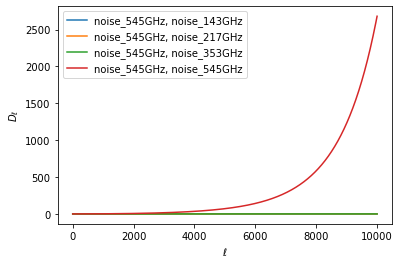

<ipython-input-60-13ad04d208a4>:156: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:156: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:156: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:156: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:156: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:156: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:156: RuntimeWarning: divide by zero encountered in

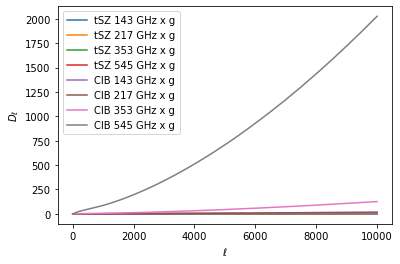

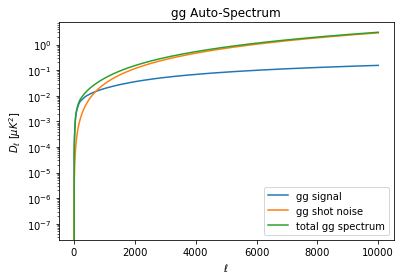

<ipython-input-60-13ad04d208a4>:187: RuntimeWarning: divide by zero encountered in true_divide
  self.gg_spectrum_signal = gg/(self.ells*(self.ells+1))*(2*np.pi)
<ipython-input-60-13ad04d208a4>:203: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*self.Clij[i][j]/(2*np.pi), label=r'$D_{\ell}$ '+f'{freqs[i]}, {freqs[j]}')
<ipython-input-60-13ad04d208a4>:203: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*self.Clij[i][j]/(2*np.pi), label=r'$D_{\ell}$ '+f'{freqs[i]}, {freqs[j]}')
<ipython-input-60-13ad04d208a4>:203: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*self.Clij[i][j]/(2*np.pi), label=r'$D_{\ell}$ '+f'{freqs[i]}, {freqs[j]}')
<ipython-input-60-13ad04d208a4>:203: RuntimeWarning: invalid value encountered in multiply
  plt.plot(self.ells, self.ells*(self.ells+1)*self.Clij[i][j]/(2*np.pi), label=r'$D_{\ell}$ '+f'{freqs[i]}, {fr

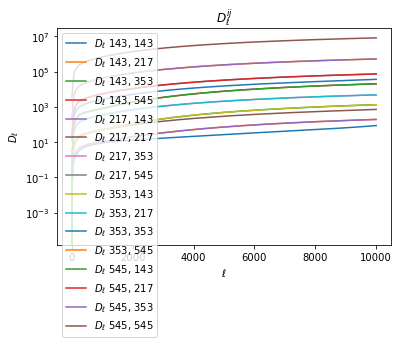

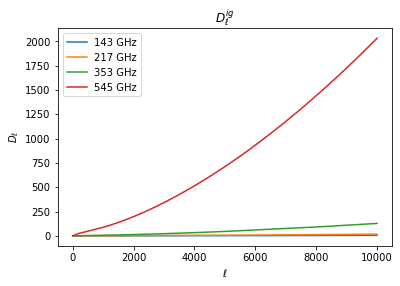

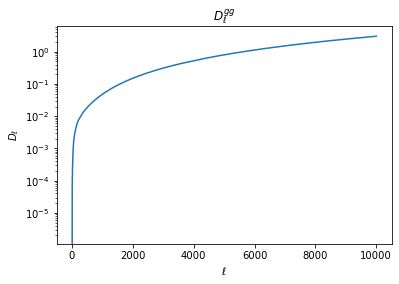

[ 0.00000000e+00 -3.62357528e-04 -1.00547845e-04 ...  9.68599754e-09
  9.68486692e-09  9.68373656e-09]


In [61]:
ellmax = 10000
ells = np.arange(ellmax+1)
base_dir = 'websky-10-18'
# freqs = [90, 145, 217, 353]
freqs = [143, 217, 353, 545]
# comps = ['CMB', 'tSZ', 'kSZ', 'CIB', 'noise']
comps = ['tSZ', 'kSZ', 'CIB', 'noise']
gg_shot_noise = 1.81e-7 #orig
# gg_shot_noise = 1.81e-9
# gg_shot_noise = 1000.

#uncomment below and add noise parameter for 1 uK arcmin noise 
noise_cl = np.zeros((len(freqs), ellmax+1))
for i in range(len(freqs)):
    if i<len(freqs)-2:
        noise = 1.
    else: #make noise higher for higher frequency :
        noise = 10.
    theta_fwhm = (1.4/60.)*(np.pi/180.)
    sigma = theta_fwhm/np.sqrt(8.*np.log(2.))
    W = (noise/60.)*(np.pi/180.)
    noise_cl[i] = W**2*np.exp(ells*(ells+1)*sigma**2)

# spectra1 = spectra(base_dir, ellmax, freqs, comps, gg_shot_noise, noise=None) #use this line for ACT noise levels
spectra1 = spectra(base_dir, ellmax, freqs, comps, gg_shot_noise, noise=noise_cl) #use this line for 1 uk arcmin noise levels
spectra1.get_cls(plot=True)
print(spectra1.gg_spectrum_signal)


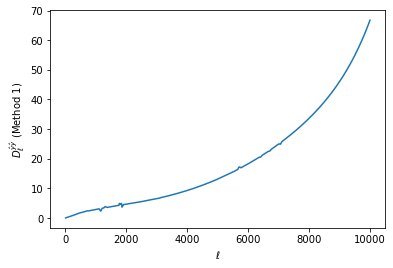

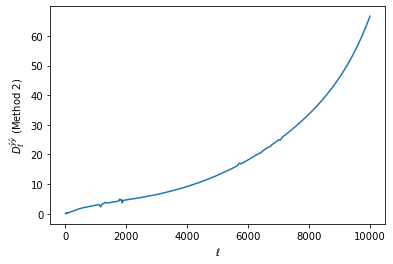

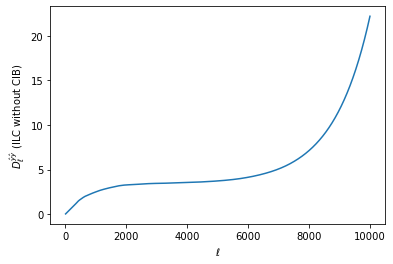

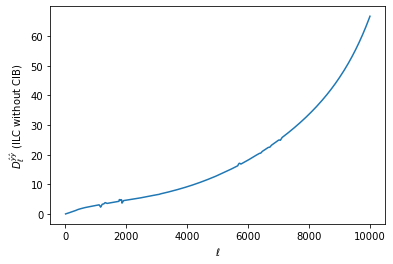

array([           nan,            nan,            nan, ...,
       4.18619138e-06, 4.18710307e-06, 4.18801557e-06])

In [62]:
deltal = 5
m1 = Method1(spectra1, deltal)
m1.ILC_auto_spectrum(plot=True)
m2 = Method2(spectra1, deltal)
m2.ILC_auto_spectrum(plot=True)
m3 = ILC_no_CIB(spectra1, deltal)
m3.ILC_auto_spectrum(plot=True)
m4 = ILC_no_g(spectra1, deltal)
m4.ILC_auto_spectrum(plot=True)

## Compare ILC Map Auto-Spectra from Method 1, Method 2, and ILC without CIB

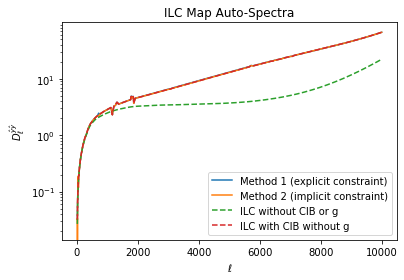

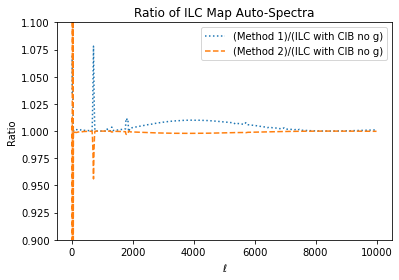

In [63]:
start = 10
stop = 10000

plt.clf()
plt.plot(ells[start:stop], (ells*(ells+1)*m1.Clyy/(2*np.pi))[start:stop], label='Method 1 (explicit constraint)')
plt.plot(ells[start:stop], (ells*(ells+1)*m2.Clyy/(2*np.pi))[start:stop], label='Method 2 (implicit constraint)')
plt.plot(ells[start:stop], (ells*(ells+1)*m3.Clyy/(2*np.pi))[start:stop], label='ILC without CIB or g', linestyle='dashed')
plt.plot(ells[start:stop], (ells*(ells+1)*m4.Clyy/(2*np.pi))[start:stop], label='ILC with CIB without g', linestyle='dashed')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[0][0]/(2*np.pi))[2:], label=r'$C_{\ell}^{90x90}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[0][1]/(2*np.pi))[2:], label=r'$C_{\ell}^{90x145}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[0][2]/(2*np.pi))[2:], label=r'$C_{\ell}^{90x217}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[0][3]/(2*np.pi))[2:], label=r'$C_{\ell}^{90x353}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[1][1]/(2*np.pi))[2:], label=r'$C_{\ell}^{145x145}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[1][2]/(2*np.pi))[2:], label=r'$C_{\ell}^{145x217}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[1][3]/(2*np.pi))[2:], label=r'$C_{\ell}^{145x353}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[2][2]/(2*np.pi))[2:], label=r'$C_{\ell}^{217x217}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[2][3]/(2*np.pi))[2:], label=r'$C_{\ell}^{217x353}$', linestyle='dotted')
# plt.plot(ells[2:], (ells*(ells+1)*spectra1.Clij[3][3]/(2*np.pi))[2:], label=r'$C_{\ell}^{353x353}$', linestyle='dotted')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$')
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.title('ILC Map Auto-Spectra')
plt.show()


plt.clf()
# plt.plot(ells[start:stop], (m1.Clyy/m2.Clyy)[start:stop], label='Method1/Method2')
# plt.plot(ells[start:stop], (m1.Clyy/m3.Clyy)[start:stop], label='Method1/(ILC without CIB)', linestyle='dashed')
# plt.plot(ells[start:stop], (m2.Clyy/m3.Clyy)[start:stop], label='Method2/(ILC without CIB)', linestyle='solid')
# plt.plot(ells[start:stop], (m4.Clyy/m3.Clyy)[start:stop], label='(ILC with CIB)/(ILC without CIB)', linestyle='solid')
plt.plot(ells[start:stop], (m1.Clyy/m4.Clyy)[start:stop], label='(Method 1)/(ILC with CIB no g)', linestyle='dotted')
plt.plot(ells[start:stop], (m2.Clyy/m4.Clyy)[start:stop], label='(Method 2)/(ILC with CIB no g)', linestyle='dashed')
epsilon = 0.1
plt.ylim(1-epsilon,1+epsilon)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel('Ratio')
plt.title('Ratio of ILC Map Auto-Spectra')
plt.show()

In [11]:
m2.w

array([[ 2.55871453e+01,  7.19578779e+00,  3.85365745e+00, ...,
         4.13984282e-01,  4.13984658e-01,  4.13985033e-01],
       [-3.71207569e+01, -9.73252774e+00, -4.75550438e+00, ...,
         3.63217885e-01,  3.63217384e-01,  3.63216883e-01],
       [ 1.30560681e+01,  3.68987929e+00,  1.98790260e+00, ...,
         2.42195884e-01,  2.42195978e-01,  2.42196072e-01],
       [-5.22456495e-01, -1.53139339e-01, -8.60556660e-02, ...,
        -1.93980507e-02, -1.93980193e-02, -1.93979879e-02],
       [-3.96200205e+02, -1.26852607e+02, -7.79176711e+01, ...,
        -5.13214696e-02, -5.13450730e-02, -5.13687151e-02]])

## Check that ILC map has zero correlation with g map

<ipython-input-12-87f2b6198498>:2: RuntimeWarning: invalid value encountered in sqrt
  ILC_g_corr_method1 = np.einsum('il,il->l', m1.w,spectra1.Clig) / np.sqrt(m1.Clyy*spectra1.Clgg)
<ipython-input-12-87f2b6198498>:2: RuntimeWarning: invalid value encountered in true_divide
  ILC_g_corr_method1 = np.einsum('il,il->l', m1.w,spectra1.Clig) / np.sqrt(m1.Clyy*spectra1.Clgg)
<ipython-input-12-87f2b6198498>:3: RuntimeWarning: invalid value encountered in sqrt
  ILC_g_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((spectra1.Clig, [spectra1.Clgg]))) / np.sqrt(m2.Clyy*spectra1.Clgg)
<ipython-input-12-87f2b6198498>:4: RuntimeWarning: invalid value encountered in sqrt
  ILC_g_corr_method4 = np.einsum('il,il->l', m4.w,spectra1.Clig) / np.sqrt(m4.Clyy*spectra1.Clgg)


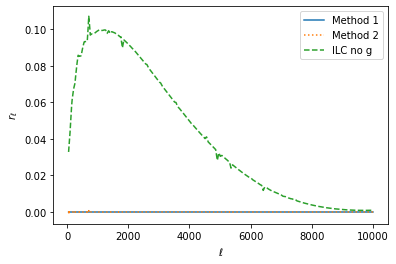

array([-5.25240824e-01,  1.99640157e-01,  1.49661874e-01, ...,
        6.41186439e-08,  8.53199566e-08,  1.06460784e-07])

In [12]:
start = 50
ILC_g_corr_method1 = np.einsum('il,il->l', m1.w,spectra1.Clig) / np.sqrt(m1.Clyy*spectra1.Clgg)
ILC_g_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((spectra1.Clig, [spectra1.Clgg]))) / np.sqrt(m2.Clyy*spectra1.Clgg)
ILC_g_corr_method4 = np.einsum('il,il->l', m4.w,spectra1.Clig) / np.sqrt(m4.Clyy*spectra1.Clgg)
plt.plot(ells[start:], ILC_g_corr_method1[start:], label='Method 1')
plt.plot(ells[start:], ILC_g_corr_method2[start:], label='Method 2', linestyle='dotted')
plt.plot(ells[start:], ILC_g_corr_method4[start:], label='ILC no g', linestyle='dashed')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$r_{\ell}$')
plt.legend()
plt.show()
ILC_g_corr_method2

## Check correlation of CIB with final ILC map

<ipython-input-13-d56602f0747e>:22: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:22: RuntimeWarning: invalid value encountered in true_divide
  ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:23: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:23: RuntimeWarning: invalid value encountered in true_divide
  ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:24: RuntimeWarning: invalid value enco

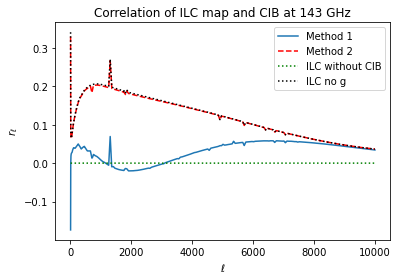

<ipython-input-13-d56602f0747e>:22: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:22: RuntimeWarning: invalid value encountered in true_divide
  ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:23: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:23: RuntimeWarning: invalid value encountered in true_divide
  ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:24: RuntimeWarning: invalid value enco

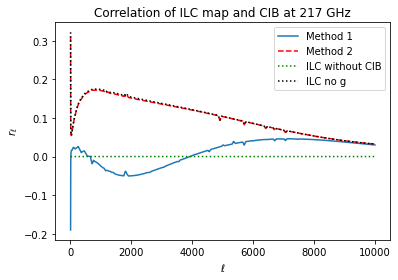

<ipython-input-13-d56602f0747e>:22: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:22: RuntimeWarning: invalid value encountered in true_divide
  ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:23: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:23: RuntimeWarning: invalid value encountered in true_divide
  ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:24: RuntimeWarning: invalid value enco

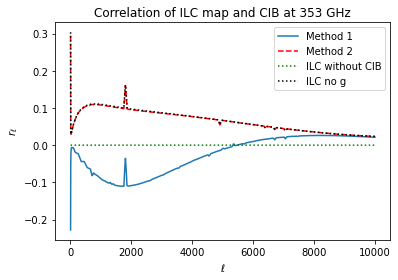

<ipython-input-13-d56602f0747e>:22: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:22: RuntimeWarning: invalid value encountered in true_divide
  ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:23: RuntimeWarning: invalid value encountered in sqrt
  ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:23: RuntimeWarning: invalid value encountered in true_divide
  ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
<ipython-input-13-d56602f0747e>:24: RuntimeWarning: invalid value enco

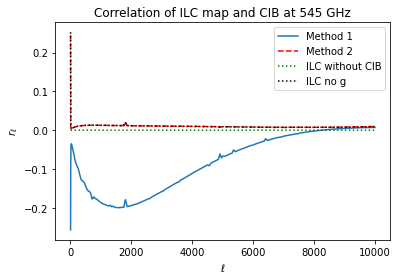

In [13]:
comp_cross_cib_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

cib_idx = spectra1.comps.index('CIB')

#index all_spectra as all_spectra[a][i][b][j]
comp_cross_cib_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[cib_idx])

#index as comp_cross_g_spectra[a][i] for cross-spectrum of g with component a at frequency i
cib_cross_g_spectrum = spectra1.comp_cross_g_spectra[cib_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_cib_spectra = np.einsum('ibjl->ijl', compnocib_cross_cib_spectra[cib_idx])


for i,freq1 in enumerate(spectra1.freqs):
    Cl_i_cib = comp_cross_cib_spectra[i]
    Cl_g_cib = cib_cross_g_spectrum[i]
    Cl_inocib_cib = compnocib_cross_cib_spectra[i]


    ILC_CIB_corr_method1 = np.einsum('il,il->l', m1.w,Cl_i_cib) / np.sqrt(m1.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method2 = np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / np.sqrt(m2.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_cib) / np.sqrt(m3.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method4 = np.einsum('il,il->l', m4.w,Cl_i_cib) / np.sqrt(m4.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    
    start = 10
    plt.plot(ells[start:], ILC_CIB_corr_method1[start:], label=f'Method 1')
    plt.plot(ells[start:], ILC_CIB_corr_method2[start:], label=f'Method 2', linestyle='dashed', color='red')
    plt.plot(ells[start:], ILC_CIB_corr_method3[start:], label=f'ILC without CIB', linestyle='dotted', color='green')
    plt.plot(ells[start:], ILC_CIB_corr_method4[start:], label=f'ILC no g', linestyle='dotted', color='black')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$r_{\ell}$')
    plt.title(f'Correlation of ILC map and CIB at {freq1} GHz')
    plt.legend()
    plt.show()

## Check fraction of CIB removed

<ipython-input-14-acad0a7a7809>:22: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method1 = 1-np.einsum('il,il->l', m1.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:23: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method2 = 1-np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:24: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method3 = 1-np.einsum('il,il->l', m3.w,Cl_inocib_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:25: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method4 = 1-np.einsum('il,il->l', m4.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]


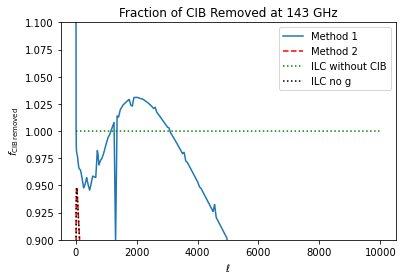

<ipython-input-14-acad0a7a7809>:22: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method1 = 1-np.einsum('il,il->l', m1.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:23: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method2 = 1-np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:24: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method3 = 1-np.einsum('il,il->l', m3.w,Cl_inocib_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:25: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method4 = 1-np.einsum('il,il->l', m4.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]


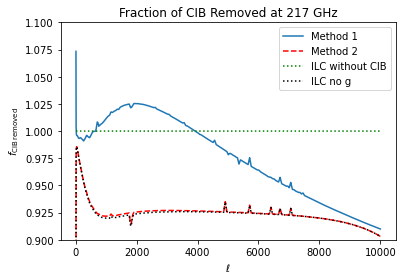

<ipython-input-14-acad0a7a7809>:22: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method1 = 1-np.einsum('il,il->l', m1.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:23: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method2 = 1-np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:24: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method3 = 1-np.einsum('il,il->l', m3.w,Cl_inocib_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:25: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method4 = 1-np.einsum('il,il->l', m4.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]


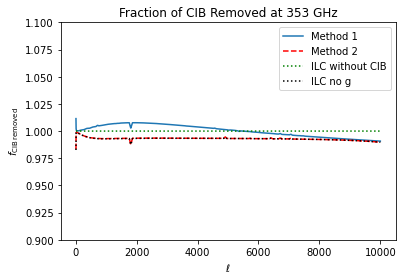

<ipython-input-14-acad0a7a7809>:22: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method1 = 1-np.einsum('il,il->l', m1.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:23: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method2 = 1-np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:24: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method3 = 1-np.einsum('il,il->l', m3.w,Cl_inocib_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
<ipython-input-14-acad0a7a7809>:25: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method4 = 1-np.einsum('il,il->l', m4.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]


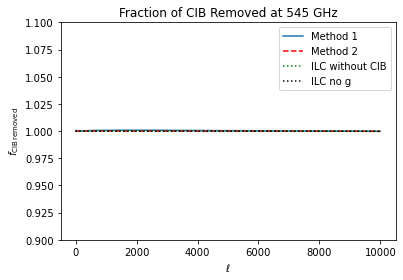

In [14]:
comp_cross_cib_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

cib_idx = spectra1.comps.index('CIB')

#index all_spectra as all_spectra[a][i][b][j]
comp_cross_cib_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[cib_idx])

#index as comp_cross_g_spectra[a][i] for cross-spectrum of g with component a at frequency i
cib_cross_g_spectrum = spectra1.comp_cross_g_spectra[cib_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_cib_spectra = np.einsum('ibjl->ijl', compnocib_cross_cib_spectra[cib_idx])


for i,freq1 in enumerate(spectra1.freqs):
    Cl_i_cib = comp_cross_cib_spectra[i]
    Cl_g_cib = cib_cross_g_spectrum[i]
    Cl_inocib_cib = compnocib_cross_cib_spectra[i]


    f_CIB_removed_method1 = 1-np.einsum('il,il->l', m1.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
    f_CIB_removed_method2 = 1-np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
    f_CIB_removed_method3 = 1-np.einsum('il,il->l', m3.w,Cl_inocib_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
    f_CIB_removed_method4 = 1-np.einsum('il,il->l', m4.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
    
    start = 10
    epsilon_high = 0.1
    epsilon_low = 0.1
    plt.plot(ells[start:], f_CIB_removed_method1[start:], label=f'Method 1')
    plt.plot(ells[start:], f_CIB_removed_method2[start:], label=f'Method 2', linestyle='dashed', color='red')
    plt.plot(ells[start:], f_CIB_removed_method3[start:], label=f'ILC without CIB', linestyle='dotted', color='green')
    plt.plot(ells[start:], f_CIB_removed_method4[start:], label=f'ILC no g', linestyle='dotted', color='black')
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$f_{\mathrm{CIB \, removed}}$')
    plt.title(f'Fraction of CIB Removed at {freq1} GHz')
    plt.ylim(1.0-epsilon_low, 1.0+epsilon_high)
    plt.legend()
    plt.show()

## Check fraction of CIB removed summed over all CIB frequencies

<ipython-input-15-5cd73ad251c7>:23: RuntimeWarning: divide by zero encountered in true_divide
  f_CIB_removed_method1 = 1-np.einsum('il,jil,jjl->l', m1.w,comp_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :])
<ipython-input-15-5cd73ad251c7>:24: RuntimeWarning: divide by zero encountered in true_divide
  f_CIB_removed_method3 = 1-np.einsum('il,jil,jjl->l', m3.w,compnocib_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :])
<ipython-input-15-5cd73ad251c7>:25: RuntimeWarning: divide by zero encountered in true_divide
  f_CIB_removed_method4 = 1-np.einsum('il,jil,jjl->l', m4.w,comp_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :])
<ipython-input-15-5cd73ad251c7>:31: RuntimeWarning: invalid value encountered in true_divide
  f_CIB_removed_method2 -= np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / spectra1.all_spectra[cib_idx][j][cib_idx][j]


m1.w.shape:  (4, 10001)
comp_cross_cib_spectra.shape:  (4, 4, 10001)
cib_cross_g_spectrum.shape:  (4, 10001)


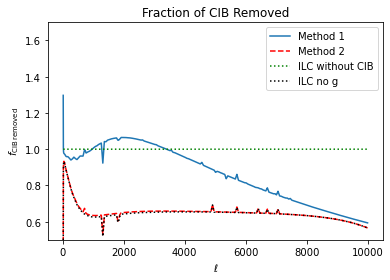

In [15]:
comp_cross_cib_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

cib_idx = spectra1.comps.index('CIB')

#index all_spectra as all_spectra[a][i][b][j]
comp_cross_cib_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[cib_idx])

#index as comp_cross_g_spectra[a][i] for cross-spectrum of g with component a at frequency i
cib_cross_g_spectrum = spectra1.comp_cross_g_spectra[cib_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_cib_spectra = np.einsum('ibjl->ijl', compnocib_cross_cib_spectra[cib_idx])


# Cl_i_cib = comp_cross_cib_spectra[i]
# Cl_g_cib = cib_cross_g_spectrum[i]
# Cl_inocib_cib = compnocib_cross_cib_spectra[i]

print('m1.w.shape: ',m1.w.shape)
print('comp_cross_cib_spectra.shape: ', comp_cross_cib_spectra.shape)
print('cib_cross_g_spectrum.shape: ', cib_cross_g_spectrum.shape)
f_CIB_removed_method1 = 1-np.einsum('il,jil,jjl->l', m1.w,comp_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :])
f_CIB_removed_method3 = 1-np.einsum('il,jil,jjl->l', m3.w,compnocib_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :]) 
f_CIB_removed_method4 = 1-np.einsum('il,jil,jjl->l', m4.w,comp_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :]) 

f_CIB_removed_method2 = np.ones(spectra1.ellmax+1)
for j in range(len(spectra1.freqs)):
    Cl_i_cib = comp_cross_cib_spectra[j]
    Cl_g_cib = cib_cross_g_spectrum[j]
    f_CIB_removed_method2 -= np.einsum('il,il->l', m2.w,np.concatenate((Cl_i_cib, [Cl_g_cib]))) / spectra1.all_spectra[cib_idx][j][cib_idx][j]



start = 10
epsilon_high = 0.7
epsilon_low = 0.5
plt.plot(ells[start:], f_CIB_removed_method1[start:], label=f'Method 1')
plt.plot(ells[start:], f_CIB_removed_method2[start:], label=f'Method 2', linestyle='dashed', color='red')
plt.plot(ells[start:], f_CIB_removed_method3[start:], label=f'ILC without CIB', linestyle='dotted', color='green')
plt.plot(ells[start:], f_CIB_removed_method4[start:], label=f'ILC no g', linestyle='dotted', color='black')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$f_{\mathrm{CIB \, removed}}$')
plt.title(f'Fraction of CIB Removed')
plt.ylim(1.0-epsilon_low, 1.0+epsilon_high)
plt.legend()
plt.show()

## Check correlation of CIB with g

<ipython-input-16-6d3035974f43>:5: RuntimeWarning: invalid value encountered in sqrt
  corr = CIBxg/np.sqrt(spectra1.all_spectra[cib_idx][i][cib_idx][i]*spectra1.gg_spectrum)
<ipython-input-16-6d3035974f43>:5: RuntimeWarning: invalid value encountered in true_divide
  corr = CIBxg/np.sqrt(spectra1.all_spectra[cib_idx][i][cib_idx][i]*spectra1.gg_spectrum)
<ipython-input-16-6d3035974f43>:5: RuntimeWarning: invalid value encountered in sqrt
  corr = CIBxg/np.sqrt(spectra1.all_spectra[cib_idx][i][cib_idx][i]*spectra1.gg_spectrum)
<ipython-input-16-6d3035974f43>:5: RuntimeWarning: invalid value encountered in true_divide
  corr = CIBxg/np.sqrt(spectra1.all_spectra[cib_idx][i][cib_idx][i]*spectra1.gg_spectrum)
<ipython-input-16-6d3035974f43>:5: RuntimeWarning: invalid value encountered in true_divide
  corr = CIBxg/np.sqrt(spectra1.all_spectra[cib_idx][i][cib_idx][i]*spectra1.gg_spectrum)
<ipython-input-16-6d3035974f43>:5: RuntimeWarning: invalid value encountered in sqrt
  corr = CIBxg/np.s

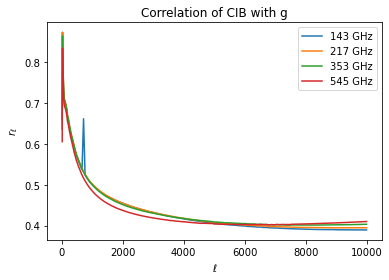

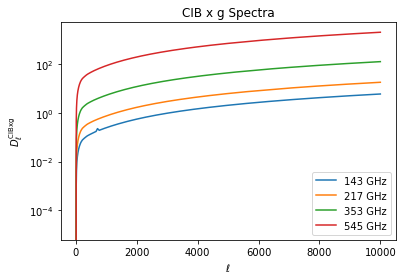

In [16]:
plt.clf()
cib_idx = spectra1.comps.index('CIB')
for i in range(len(spectra1.freqs)):
    CIBxg = spectra1.comp_cross_g_spectra[cib_idx][i]
    corr = CIBxg/np.sqrt(spectra1.all_spectra[cib_idx][i][cib_idx][i]*spectra1.gg_spectrum)
    plt.plot(ells[10:], corr[10:], label=f'{freqs[i]} GHz')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$r_{\ell}$')
# plt.yscale('log')
plt.legend()
plt.title('Correlation of CIB with g')
plt.show()


plt.clf()
cib_idx = spectra1.comps.index('CIB')
for i in range(len(spectra1.freqs)):
    CIBxg = spectra1.comp_cross_g_spectra[cib_idx][i]
    plt.plot(ells[2:], (ells*(ells+1)*CIBxg/(2*np.pi))[2:], label=f'{freqs[i]} GHz')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}^{\mathrm{CIBxg}}$')
plt.yscale('log')
plt.legend()
plt.title('CIB x g Spectra')
plt.show()

In [17]:
i = 0
spectra1.comp_cross_g_spectra[cib_idx][i]

array([ 0.00000000e+00, -8.70698659e-03, -2.48537420e-03, ...,
        3.71675434e-07,  3.71658846e-07,  3.71642258e-07])

In [18]:
spectra1.all_spectra[cib_idx][i][cib_idx][i]

array([ 0.00000000e+00, -1.76854575e-01, -4.95586067e-02, ...,
        4.78175949e-06,  4.78136506e-06,  4.78097070e-06])

In [19]:
spectra1.gg_spectrum

array([ 1.81000000e-07, -3.62176528e-04, -1.00366845e-04, ...,
        1.90685998e-07,  1.90684867e-07,  1.90683737e-07])

In [20]:
corr

array([        nan, -1.18843696, -1.25021004, ...,  0.40978219,
        0.40978541,  0.40978863])

## Check correlation of tSZ with g

<ipython-input-21-94eb8e18925f>:6: RuntimeWarning: invalid value encountered in sqrt
  corr = tszxg/np.sqrt(spectra1.all_spectra[tsz_idx][i][tsz_idx][i]*spectra1.gg_spectrum)
<ipython-input-21-94eb8e18925f>:6: RuntimeWarning: invalid value encountered in true_divide
  corr = tszxg/np.sqrt(spectra1.all_spectra[tsz_idx][i][tsz_idx][i]*spectra1.gg_spectrum)
<ipython-input-21-94eb8e18925f>:6: RuntimeWarning: invalid value encountered in sqrt
  corr = tszxg/np.sqrt(spectra1.all_spectra[tsz_idx][i][tsz_idx][i]*spectra1.gg_spectrum)
<ipython-input-21-94eb8e18925f>:6: RuntimeWarning: invalid value encountered in true_divide
  corr = tszxg/np.sqrt(spectra1.all_spectra[tsz_idx][i][tsz_idx][i]*spectra1.gg_spectrum)
<ipython-input-21-94eb8e18925f>:6: RuntimeWarning: invalid value encountered in sqrt
  corr = tszxg/np.sqrt(spectra1.all_spectra[tsz_idx][i][tsz_idx][i]*spectra1.gg_spectrum)
<ipython-input-21-94eb8e18925f>:6: RuntimeWarning: invalid value encountered in true_divide
  corr = tszxg/np.s

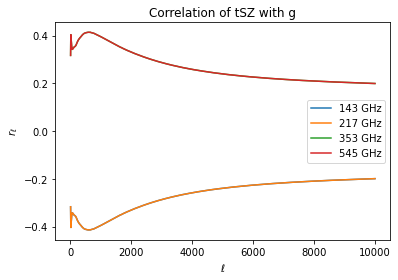

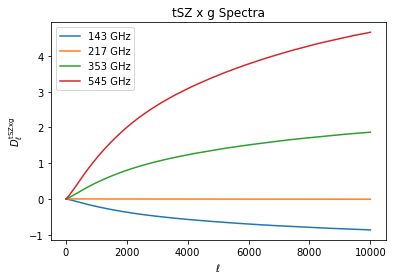

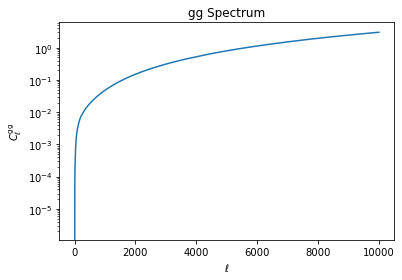

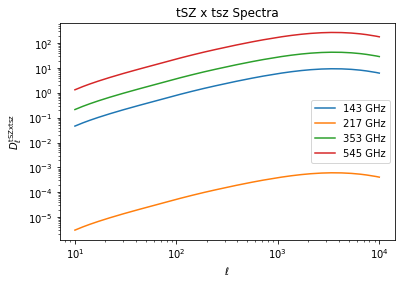

In [21]:
plt.clf()
tsz_idx = spectra1.comps.index('tSZ')
# for i in range(len(spectra1.freqs)):
for i in range(4):
    tszxg = spectra1.comp_cross_g_spectra[tsz_idx][i]
    corr = tszxg/np.sqrt(spectra1.all_spectra[tsz_idx][i][tsz_idx][i]*spectra1.gg_spectrum)
    plt.plot(ells[10:], corr[10:], label=f'{freqs[i]} GHz')
    
    
plt.xlabel(r'$\ell$')
plt.ylabel(r'$r_{\ell}$')
# plt.yscale('log')
plt.legend()
plt.title('Correlation of tSZ with g')
plt.show()


#tsz x g
plt.clf()
tsz_idx = spectra1.comps.index('tSZ')
for i in range(len(spectra1.freqs)):
    tszxg = spectra1.comp_cross_g_spectra[tsz_idx][i]
    plt.plot(ells[2:], (ells*(ells+1)*tszxg/(2*np.pi))[2:], label=f'{freqs[i]} GHz')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}^{\mathrm{tSZxg}}$')
# plt.yscale('log')
plt.legend()
plt.title('tSZ x g Spectra')
plt.show()

#gg
plt.clf()
plt.plot(ells[2:], (ells*(ells+1)*spectra1.gg_spectrum/(2*np.pi))[2:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}^{\mathrm{gg}}$')
plt.yscale('log')
plt.title('gg Spectrum')
plt.show()

#tsz x tsz
plt.clf()
tsz_idx = spectra1.comps.index('tSZ')
for i in range(len(spectra1.freqs)):
    tszxtsz = spectra1.all_spectra[tsz_idx][i][tsz_idx][i]
#     plt.plot(ells[10:], tszxtsz[10:], label=f'{freqs[i]} GHz')
    plt.plot(ells[10:], (ells*(ells+1)*tszxtsz/(2*np.pi))[10:], label=f'{freqs[i]} GHz')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}^{\mathrm{tSZxtsz}}$')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('tSZ x tsz Spectra')
plt.show()




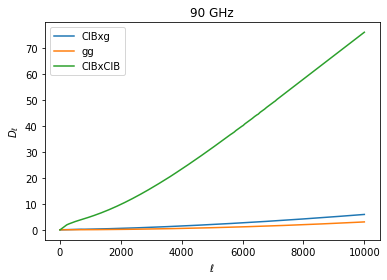

In [22]:
#show gg, g x CIB (for some CIB frequency), and CIB auto for that frequency
plt.clf()
cib_idx = spectra1.comps.index('CIB')
i = 0
CIBxg = spectra1.comp_cross_g_spectra[cib_idx][i]
plt.plot(ells[2:], (ells*(ells+1)*CIBxg/(2*np.pi))[2:], label=f'CIBxg')
plt.plot(ells[2:], (ells*(ells+1)*spectra1.gg_spectrum/(2*np.pi))[2:], label=f'gg')
plt.plot(ells[2:], (ells*(ells+1)*spectra1.all_spectra[cib_idx][i][cib_idx][i]/(2*np.pi))[2:], label=f'CIBxCIB')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}$')
# plt.yscale('log')
plt.legend()
plt.title('90 GHz')
plt.show()


<ipython-input-23-4165b0d96764>:8: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(spectra1.ells[200:], (spectra1.all_spectra[cib_idx][i][tsz_idx][j]/np.sqrt(spectra1.all_spectra[tsz_idx][j][tsz_idx][j]*spectra1.all_spectra[cib_idx][i][cib_idx][i]))[200:], label=f'CIB {freq1} GHz x tSZ {freq2} GHz')
<ipython-input-23-4165b0d96764>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(spectra1.ells[200:], (spectra1.all_spectra[cib_idx][i][tsz_idx][j]/np.sqrt(spectra1.all_spectra[tsz_idx][j][tsz_idx][j]*spectra1.all_spectra[cib_idx][i][cib_idx][i]))[200:], label=f'CIB {freq1} GHz x tSZ {freq2} GHz')
<ipython-input-23-4165b0d96764>:8: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(spectra1.ells[200:], (spectra1.all_spectra[cib_idx][i][tsz_idx][j]/np.sqrt(spectra1.all_spectra[tsz_idx][j][tsz_idx][j]*spectra1.all_spectra[cib_idx][i][cib_idx][i]))[200:], label=f'CIB {freq1} GHz x tSZ {freq2} GHz')
<ipython-input-23-4165b0d96764>:8: RuntimeWarning: 

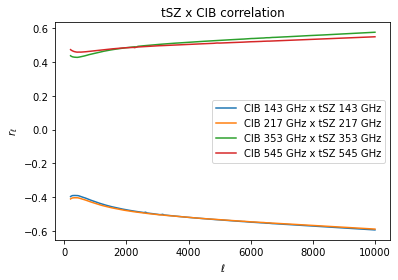

In [23]:
#check correlation of tSZ and CIB
plt.clf()
cib_idx = spectra1.comps.index('CIB')
tsz_idx = spectra1.comps.index('tSZ')
for i, freq1 in enumerate(spectra1.freqs):
    for j, freq2 in enumerate(spectra1.freqs):
        if freq1==freq2:
            plt.plot(spectra1.ells[200:], (spectra1.all_spectra[cib_idx][i][tsz_idx][j]/np.sqrt(spectra1.all_spectra[tsz_idx][j][tsz_idx][j]*spectra1.all_spectra[cib_idx][i][cib_idx][i]))[200:], label=f'CIB {freq1} GHz x tSZ {freq2} GHz')
        
plt.xlabel(r'$\ell$')
plt.ylabel(r'$r_{\ell}$')
# plt.yscale('log')
plt.legend()
plt.title('tSZ x CIB correlation')
plt.show()